### **다중 에이전트로 보고서 만들기**

In [1]:
!pip install -q \
    langchain langchain-core langchain-community langchain-openai \
    langgraph \
    python-docx \
    tavily-python \
    openai


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 35.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.8/84.8 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.0/253.0 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 3.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.


In [2]:
import os
import warnings
warnings.filterwarnings('ignore')
from google.colab import userdata
os.environ["OPENAI_API_KEY"] = userdata.get("OPENAI_API_KEY")
os.environ["TAVILY_API_KEY"] = userdata.get("tavily")

# 타입 힌트 관련 모듈 가져오기
from typing import Annotated, TypedDict, List, Dict, Sequence, Optional

# 랭그래프에서 그래프 생성을 위한 클래스 및 상수 가져오기
from langgraph.graph import StateGraph, START, END
# 랭그래프에서 메시지 추적 기능 추가 유틸리티
from langgraph.graph.message import add_messages

# 랭체인 메시지 / 프롬프트 / 파서
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import JsonOutputParser

# Pydantic 모델 동적 생성용
from pydantic import Field, create_model

# Word(docx) 생성용
from docx import Document

# Optional: 그래프 구조 PNG 출력용
from IPython.display import Image as IPyImage, display

# 상태(State) 구조 정의
class State(TypedDict):
    # 메시지 목록을 추적하며 누적 저장(랭그래프의 add_messages 기능 적용)
    messages: Annotated[Sequence[BaseMessage], add_messages]
    # 생성된 목차 정보를 저장(예: {"1": "서론", "2": "본론", ...})
    outline: Dict[str, str]
    # 현재 작성 중인 섹션 번호(1부터 시작)
    current_section: int
    # 현재 섹션에서 생성된 본문 콘텐츠
    section_content: str
    # 전체 섹션 수(사용자가 설정한 총 섹션 수)
    total_sections: int
    # 전체 보고서 구성: 각 섹션의 제목, 본문 등을 리스트로 저장
    full_report: List[Dict[str, str]]
    # 생성된 docx 파일명
    report_file: Optional[str]

In [3]:
# Tavily 웹 검색
from langchain_community.tools.tavily_search import TavilySearchResults
# 검색 결과 3개까지 사용
search = TavilySearchResults(max_results=3)

/tmp/ipython-input-1441004824.py:4: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  search = TavilySearchResults(max_results=3)


In [4]:
# OpenAI 모델
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.3)

In [5]:
# 개요 작성 에이전트

# 사용자가 원하는 섹션 개수에 따라 동적으로 Pydantic 모델을 생성하는 함수
def create_outline_model(section_count: int):
    # 딕셔너리 컴프리헨션을 통해 section1, section2, ..., section{n} 형태의 필드를 생성
    # 각 필드는 문자열(str) 타입이며, Field를 사용하여 설명(description)을 부여함
    fields = {
        f"section{i}": (str, Field(description=f"Title for section {i}"))
        for i in range(1, section_count + 1)
    }
    # create_model은 런타임에 새로운 Pydantic 모델 클래스를 생성하는 함수
    # 첫 번째 인자는 모델의 이름, 이후는 필드들을 키워드 인자(fields)로 전달
    return create_model("DynamicOutline", **fields)

def outline_generator(state: State):
    # 섹션 수에 맞는 동적 Pydantic 모델 생성
    DynamicOutline = create_outline_model(state["total_sections"])
    outline_parser = JsonOutputParser(pydantic_object=DynamicOutline)

    # 개요 생성 프롬프트 템플릿
    prompt = PromptTemplate(
        template=(
            "아래 주제에 대해 {section_count}개의 주요 섹션으로 구성된 보고서 개요를 작성해줘.\n"
            "각 섹션은 간결하고 명확한 제목으로 구성해줘.\n\n"
            "출력 형식:\n{format_instructions}\n\n"
            "주제: {topic}"
        ),
        input_variables=["section_count", "topic"],
        partial_variables={"format_instructions": outline_parser.get_format_instructions()},
    )

    # 프롬프트 → LLM → 파서로 연결된 체인 구성
    chain = prompt | llm | outline_parser

    # 실행: 사용자 메시지를 토픽으로 사용
    topic = state["messages"][-1].content
    outline_obj = chain.invoke({"section_count": state["total_sections"], "topic": topic})

    # dict 형태로 변환
    outline = outline_obj.model_dump() if hasattr(outline_obj, "model_dump") else dict(outline_obj)

    # 생성된 개요 출력
    print("=== 개요 ===")
    for k, v in outline.items():
        print(f"{k}: {v}")

    return {"outline": outline}

In [6]:
# 콘텐츠 작성 에이전트

def contents_writer(state: State):
    # 현재 섹션이 전체 섹션보다 크면 >> 보고서 완성
    if state["current_section"] > state["total_sections"]:
        return {"messages": [AIMessage(content="All sections already completed.")]}

    # 현재 섹션 제목
    key = f"section{state['current_section']}"
    topic = state["outline"][key]

    # Tavily 검색 결과 가져오기
    try:
        search_results = search.invoke(topic)
    except Exception as e:
        search_results = f"Tavily search failed: {e}"

    # 이전 섹션들 연결성 확보용
    previous_sections = "\n\n".join(
        [f"[Section {i}] {sec['title']}\n{sec['content']}"
         for i, sec in enumerate(state["full_report"], start=1)]
    ) or "없음"

    # 섹션 본문 생성 프롬프트
    prompt = PromptTemplate(
        template=(
            "다음 주제에 대한 상세 보고서 섹션을 작성해줘:\n"
            "- 주제: {topic}\n\n"
            "검색 결과:\n{search_results}\n\n"
            "이전 섹션 내용:\n{previous_sections}\n\n"
            "요구사항:\n"
            "- 이미지 생성 관련 문구 절대 금지\n"
            "- 구체적 정보, 수치 포함 가능\n"
            "- 자연스러운 한국어 보고서 스타일"
        ),
        input_variables=["topic", "search_results", "previous_sections"],
    )

    final_prompt = prompt.format(
        topic=topic,
        search_results=search_results,
        previous_sections=previous_sections,
    )

    # GPT 호출
    llm_result = llm.invoke(final_prompt)

    return {"section_content": llm_result.content}

# 섹션 누적 노드
def section_aggregator(state: State):
    # 방금 생성된 섹션 내용을 full_report에 추가
    idx = state["current_section"]
    title = state["outline"][f"section{idx}"]

    # 콘솔 출력
    print("\n" + "=" * 70)
    print(f"섹션 {idx}/{state['total_sections']} : {title}")
    print("-" * 70)
    print(state["section_content"])
    print("=" * 70 + "\n")

    # full_report 업데이트
    new_list = state["full_report"] + [{
        "title": title,
        "content": state["section_content"],
    }]

    print(f"섹션 {idx}/{state['total_sections']} 생성 완료\n")

    return {
        "full_report": new_list,
        "current_section": idx + 1
    }

In [7]:
# 최종 보고서 생성 에이전트
def report_generator(state: State):
    title_text = state["messages"][0].content
    doc = Document()

    # 보고서 제목
    doc.add_heading(f"Report: {title_text}", 0)

    # 섹션들 추가
    for section in state["full_report"]:
        doc.add_heading(section["title"], level=1)
        doc.add_paragraph(section["content"])
        doc.add_page_break()

    # 안전한 파일명 생성
    safe_title = "".join(c if c.isalnum() or c in " _-" else "_" for c in title_text)
    filename = f"report_{safe_title}.docx".replace(" ", "_")

    # 파일 저장
    doc.save(filename)
    print(f"보고서 파일 저장 완료: {filename}")

    return {
        "messages": [AIMessage(content=f"Report finalized and saved as {filename}.")],
        "report_file": filename
    }

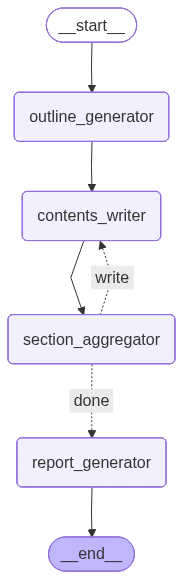

In [8]:
# 그래프 구축 에이전트
graph_builder = StateGraph(State)
# 노드 추가
graph_builder.add_node("outline_generator", outline_generator) # 개요 생성 노드
graph_builder.add_node("contents_writer", contents_writer)  # 본문 작성 노드
graph_builder.add_node("section_aggregator", section_aggregator) # 섹션 누적 노드
graph_builder.add_node("report_generator", report_generator)  # 최종 보고서 생성 노드

# 엣지(흐름 연결) 추가
graph_builder.add_edge(START, "outline_generator")
graph_builder.add_edge("outline_generator", "contents_writer")
graph_builder.add_edge("contents_writer", "section_aggregator")
graph_builder.add_edge("report_generator", END)

# 조건부 엣지(분기 조건 정의)
def should_continue_writing(state: State):
    # 현재 섹션이 전체 섹션 수 이하라면 계속 작성
    return "write" if state["current_section"] <= state["total_sections"] else "done"

graph_builder.add_conditional_edges(
    "section_aggregator",
    should_continue_writing,
    {
        "write": "contents_writer",
        "done": "report_generator",
    }
)

# 그래프 컴파일
graph = graph_builder.compile()

# 그래프 구조 시각화 (옵션)
try:
    display(IPyImage(graph.get_graph().draw_mermaid_png()))
except:
    pass  # PNG 출력 실패 시 무시



In [ ]:
# 사용자 입력받기
topic = input("보고서 주제를 입력하세요: ")
total_sections = int(input("생성할 섹션 수를 입력하세요 (예: 3, 5): "))

initial_state: State = {
    "messages": [HumanMessage(content=topic)],
    "total_sections": total_sections,
    "current_section": 1,
    "outline": {},
    "section_content": "",
    "full_report": [],
    "report_file": None,
}

print("\n=== 그래프 실행 시작 ===")

# graph.stream → 단계별 state 출력
for chunk in graph.stream(initial_state, stream_mode="values"):
    print(chunk)

print("\n=== 보고서 생성 완료 ===")


보고서 주제를 입력하세요: agi와 인간
생성할 섹션 수를 입력하세요 (예: 3, 5): 1

=== 그래프 실행 시작 ===
{'messages': [HumanMessage(content='agi와 인간', additional_kwargs={}, response_metadata={}, id='211a6abd-84a9-442e-82bb-1917a3bee4e1')], 'outline': {}, 'current_section': 1, 'section_content': '', 'total_sections': 1, 'full_report': [], 'report_file': None}
=== 개요 ===
section1: AGI와 인간: 상호작용 및 미래 전망
{'messages': [HumanMessage(content='agi와 인간', additional_kwargs={}, response_metadata={}, id='211a6abd-84a9-442e-82bb-1917a3bee4e1')], 'outline': {'section1': 'AGI와 인간: 상호작용 및 미래 전망'}, 'current_section': 1, 'section_content': '', 'total_sections': 1, 'full_report': [], 'report_file': None}
